# Datacamp project

# Predicting the Nutriscore grade of a product

##### Authors :
* Alban Petit
* Gaspard Donada--Vidal
* Ghassen Chaabane
* Moez Ezzeddine
* Nicolas Devatine

<img src="resources/nutriscore.jpg" width="250">

This starting kit requires the following dependencies :
* matplotlib
* numpy
* pandas
* seaborn
* scikit-learn
All these modules can be installed with `pip install -r requirements.txt`

You also need the ramp-workflow that can be installed directly from the GitHub repository :
`python -m pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master`

In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

# General Outline

### 1. Business case
1.1. Introduction <br/>
1.2. Business case <br/>
1.3. Data sources <br/>
1.4. Metric
### 2. Exploratory Data Analysis
2.1. Statistics / Vizualization
### 3. Model to submit
3.1. Workflow <br/>
3.2. Feature Extractor <br/>
3.3 Baseline Classifier <br/>
3.4. Evaluation
### 4. Submitting on RAMP

# 1. Business case

## 1.1. Introduction

In 2016, "Santé Publique France" unveiled the nutriscore, a 5-Color label that conveys information on the nutrional quality of food products. Every product is rated with a letter from "A" (the best grade) to "E" (the worst grade).
As of today, this system has been used by the majority of companies and retailers, despite the fact that it is not mandatory.

In January 2020, members of the European parliament suggested to extend the use of the Nutriscore.
Moreover, a petition on the website "European Citizens Initiative" (eci.ec.europa.eu) was launched in 2019 in order to impose the Nutriscore on food products.

## 1.2. Business case

The Nutriscore uses a determinist formula using the nutritional value of the products, but since it is not yet mandatory to display it on a product, would it be possible to estimate the Nutriscore even if we missed some information?
This is the goal of this competition: using incomplete information and non-numerical clues in order to assess as accurately as possible the Nutriscore of an item.

## 1.3. Data sources

<img src="resources/off.png" width="250">

The data comes exclusively from the Open Food Facts database, accessible on http://openfoodfacts.org/.
The database is available under the Open Database License and is managed by the non-profit organization Open Food Facts.
Most of the data is provided by invidual contributors that wish to help the project.

We have gathered data from their database and only selected the features we were interested in for this challenge. In addition, some product data are dirty and have incomplete information.

## 1.4. Metric

There are only five possible outputs (A, B, C, D and E) and the classes are moderately unbalanced.
The metric used should penalize depending on the distance between the predicted letter and the true letter.
In other words, it should penalize more heavily the prediction of a "E" instead of an "A" than the prediction of a "B" instead of an "A".
Moreover, since believing junk food to be health is a greater problem than the opposite, the loss function should reflect that by strongly penalizing overestimates.
So, we will convert the letter into an integer between 0 and 4 (E being 0 and A being 4) and then use the following loss function:


$$L(\hat{\theta}, \theta) = \mathbb{E}\left[(2f^+(\hat{\theta}-\theta ))^2 + (2f^+(\theta-\hat{\theta}))^{3/2}\right]$$

# 2. Exploratory Data Analysis

## 2.1 Loading data

In [2]:
from problem import get_train_data

In [3]:
X_train, y_train = get_train_data()

## 2.2 Data description

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234372 entries, 0 to 234371
Data columns (total 6 columns):
_id                 234372 non-null float64
allergens           57080 non-null object
brands              204838 non-null object
categories_tags     234371 non-null object
ingredients_tags    164835 non-null object
nova_group          147087 non-null float64
dtypes: float64(2), object(4)
memory usage: 10.7+ MB


In [5]:
X_train.columns

Index(['_id', 'allergens', 'brands', 'categories_tags', 'ingredients_tags',
       'nova_group'],
      dtype='object')

In [6]:
X_train.head()

,_id,allergens,brands,categories_tags,ingredients_tags,nova_group
0,3.250390e+12,en:eggs en:gluten en:lupin en:milk en:nuts en:...,Chabrior,en:snacks en:sweet-snacks en:biscuits-and-cake...,en:chocolate en:emulsifier en:flavouring en:wh...,4.0
1,5.150025e+10,NaN,JIF,en:spreads es:crema-de-cacahuate,en:ingredient en:peanut es:solidos-de-jarabe-d...,NaN
2,3.259426e+12,en:eggs en:gluten,Ker Cadélac,en:snacks en:sweet-snacks en:biscuits-and-cake...,en:wheat-flour en:cereal en:flour en:wheat en:...,4.0
3,3.123340e+12,NaN,Joker,en:plant-based-foods-and-beverages en:beverage...,fr:jus-et-purees-a-base-de-jus-concentres-de e...,3.0
4,8.000965e+12,en:gluten,consilia,en:plant-based-foods-and-beverages en:plant-ba...,it:farine en:chocolate-filling en:chocolate en...,4.0


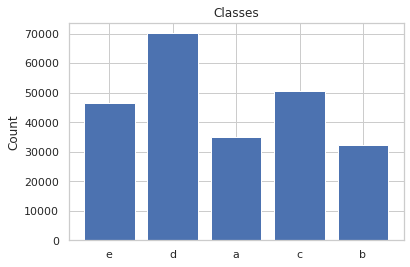

In [7]:
from collections import Counter

distribution = Counter(y_train)
plt.bar(distribution.keys(), distribution.values());

plt.ylabel('Count')
plt.title('Classes')
 
plt.show()

Print the 10 most common ingredients and categories

In [8]:
ingredients_tags = X_train[X_train['ingredients_tags'].notnull()]
ingredients_tags = ingredients_tags['ingredients_tags']
categories_tags = X_train[X_train['categories_tags'].notnull()]
categories_tags = categories_tags['categories_tags']

unique_ingredients_tags = []
nb_ingredients_distribution = []
unique_categories_tags = []
nb_categories_distribution = []

for ing in ingredients_tags:
    ing_list = ing.split()
    unique_ingredients_tags += ing_list
    nb_ingredients_distribution.append(len(ing_list))

for cat in categories_tags:
    cat_list = cat.split()
    unique_categories_tags += cat_list
    nb_categories_distribution.append(len(cat_list))
    
mean_number_of_ingredients = len(unique_ingredients_tags)/X_train.shape[0]
mean_number_of_categories = len(unique_categories_tags)/X_train.shape[0]

unique_ingredients_tags = [i.replace(' ', '') for i in unique_ingredients_tags]
unique_ingredients_tags = Counter(unique_ingredients_tags)

unique_categories_tags = [c.replace(' ', '') for c in unique_categories_tags]
unique_categories_tags = Counter(unique_categories_tags)

In [55]:
unique_ingredients_tags.most_common(10)

[('en:salt', 84512),
 ('en:sugar', 71480),
 ('en:water', 58923),
 ('en:oil-and-fat', 56757),
 ('en:flavouring', 52065),
 ('en:dairy', 51405),
 ('en:vegetable-oil-and-fat', 51142),
 ('en:cereal', 43503),
 ('en:vegetable', 43451),
 ('en:wheat', 37095)]

In [53]:
unique_categories_tags.most_common(10)

[('en:plant-based-foods-and-beverages', 69248),
 ('en:plant-based-foods', 60460),
 ('en:snacks', 40940),
 ('en:sweet-snacks', 33342),
 ('en:dairies', 29177),
 ('en:cereals-and-potatoes', 23259),
 ('en:beverages', 22539),
 ('en:meals', 21085),
 ('en:fermented-foods', 21066),
 ('en:fermented-milk-products', 20793)]

In [11]:
print("Mean number of ingredients =", mean_number_of_ingredients)
print("Mean number of categories =", mean_number_of_categories)

Mean number of ingredients = 14.034564709094942
Mean number of categories = 5.618124178656154


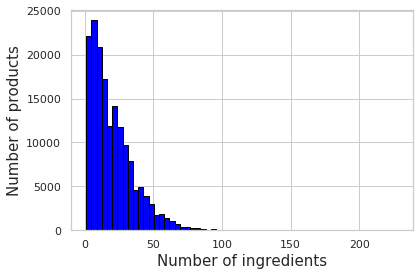

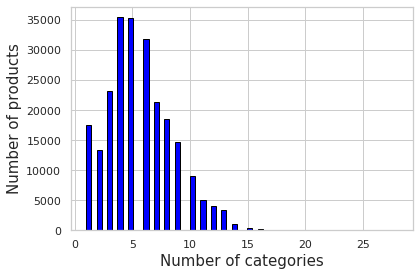

In [12]:
plt.hist(nb_ingredients_distribution, bins = int(60), color = 'blue', edgecolor = 'black')
plt.xlabel('Number of ingredients', size = 15)
plt.ylabel('Number of products', size= 15)
plt.tight_layout()
plt.show()

plt.hist(nb_categories_distribution, bins = int(60), color = 'blue', edgecolor = 'black')
plt.xlabel('Number of categories', size = 15)
plt.ylabel('Number of products', size= 15)
plt.tight_layout()
plt.show()

As it is shown on the graph below, there is an important number of ingredients and categories that appear only very few times.

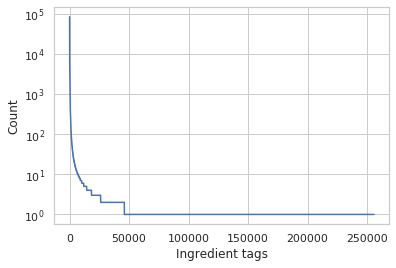

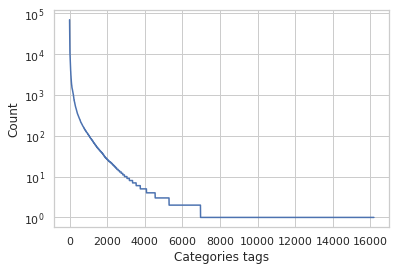

In [13]:
y = sorted(list(unique_ingredients_tags.values()), reverse=True)
x = np.arange(len(y))
plt.yscale("log")
plt.plot(x,y)
plt.xlabel("Ingredient tags")
plt.ylabel("Count")
plt.show()

y = sorted(list(unique_categories_tags.values()), reverse=True)
x = np.arange(len(y))
plt.yscale("log")
plt.plot(x,y)
plt.xlabel("Categories tags")
plt.ylabel("Count")
plt.show()

# 3. Model to submit
## 3.1. Workflow

The model works as follows :
* A feature extractor is used on the input to perform feature engineering
* The features generated are fed to a model to generate a prediction

<p> During the training, the model will use the labels to correct its behaviour. <br> Then, the model is evaluated over a test set using our metric. </p>

<img src="resources/workflow.png" width="800">

## 3.2. Feature Extractor

In [116]:
%%file submissions/starting_kit/feature_extractor.py
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OrdinalEncoder

class FeatureExtractor:
    def __init__(self):
        self.vectorizer_allergens = DictVectorizer(sparse=False)
        self.vectorizer_categories = DictVectorizer(sparse=False)
        self.vectorizer_ingredients = DictVectorizer(sparse=False)
        
    def get_features(self, X_df):
        ingredients_tags = X_df[X_df['ingredients_tags'].notnull()]
        ingredients_tags = ingredients_tags['ingredients_tags']
        categories_tags = X_df[X_df['categories_tags'].notnull()]
        categories_tags = categories_tags['categories_tags']
        allergens_tags = X_df[X_df['allergens'].notnull()]
        allergens_tags = allergens_tags['allergens']

        unique_ingredients_tags = []
        unique_categories_tags = []
        unique_allergens_tags = []
        
        for ing in ingredients_tags:
            ing_list = ing.split()
            unique_ingredients_tags += ing_list

        for cat in categories_tags:
            cat_list = cat.split()
            unique_categories_tags += cat_list
            
        for al in allergens_tags:
            al_list = al.split()
            unique_allergens_tags += al_list
            
        unique_ingredients_tags = [i.replace(' ', '') for i in unique_ingredients_tags]
        unique_ingredients_tags = Counter(unique_ingredients_tags)

        unique_categories_tags = [c.replace(' ', '') for c in unique_categories_tags]
        unique_categories_tags = Counter(unique_categories_tags)
        
        unique_allergens_tags = [a.replace(' ', '') for a in unique_allergens_tags]
        unique_allergens_tags = Counter(unique_allergens_tags)
        
        unique_ingredients_tags = [i for i, j in unique_ingredients_tags.most_common(100)]
        unique_categories_tags = [i for i, j in unique_categories_tags.most_common(100)]
        unique_allergens_tags = [i for i, j in unique_allergens_tags.most_common(100)]
    
        features_allergens = []
        features_ingredients = []
        features_categories = []
        
        for i in X_df['allergens'].fillna(""):
            features_allergens += [{j : 1 for j in i.split() if j in unique_allergens_tags}]
            
        for i in X_df['ingredients_tags'].fillna(""):
            features_ingredients += [{j : 1 for j in i.split() if j in unique_ingredients_tags}]
            
        for i in X_df['categories_tags'].fillna(""):
            features_categories += [{j : 1 for j in i.split() if j in unique_categories_tags}]
            
        return features_allergens, features_ingredients, features_categories
    
    def fit(self, X_df, y):
        features_allergens, features_ingredients, features_categories = self.get_features(X_df)
        self.vectorizer_allergens.fit(features_allergens)
        self.vectorizer_ingredients.fit(features_ingredients)
        self.vectorizer_categories.fit(features_categories)

    def transform(self, X_df):
        features_allergens, features_ingredients, features_categories = self.get_features(X_df)
        
        allergens = self.vectorizer_allergens.transform(features_allergens)
        ingredients = self.vectorizer_ingredients.transform(features_ingredients)
        categories = self.vectorizer_categories.transform(features_categories)
        nova = np.array(X_df['nova_group'].fillna(0)).reshape(-1, 1)
        
        return np.concatenate((nova, allergens, categories, ingredients), axis=1)

Overwriting submissions/starting_kit/feature_extractor.py


## 3.3. Baseline Classifier

In [117]:
%%file submissions/starting_kit/classifier.py
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = Pipeline([
            ('classifier', DecisionTreeClassifier())
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Overwriting submissions/starting_kit/classifier.py


# 4. Submitting on RAMP
You can test locally your submission before sending it to the RAMP platform backend using the command !ramp_test_submission --submission starting_kit.

The usual way to use this is to explore various models, feature transformations, hyper-parameters optimization and test them using the following command. It uses our metric to estimate your score.

To test files stored in a different folder, just replace 'starting_kit' by the name of your folder

In [ ]:
!ramp_test_submission --ramp_data_dir './data/' --submission starting_kit

Testing Nutriscore prediction
Reading train and test files from ./data//data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  nsg error       time
	train       0.31  17.576327
	valid       0.75   7.077110
	test        0.74   1.724205
CV fold 1
	score  nsg error       time
	train       0.30  19.059365
	valid       0.75   7.699781
	test        0.75   1.873810
CV fold 2
	score  nsg error      time
	train       0.30  20.85502
	valid       0.74   8.23929
	test        0.74   2.22596
CV fold 3
	score  nsg error       time
	train       0.30  17.057706
	valid       0.75   6.853784
	test        0.75   1.709563
CV fold 4
	score  nsg error       time
	train       0.30  16.025386
	valid       0.74   6.784146
	test        0.74   1.688017
CV fold 5
